MSE: 231109.73, R² Score: 0.8696
Final Accuracy (R² Score): 86.96%


C:\Users\Sanjay\AppData\Local\Temp\ipykernel_20128\2634409813.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns[sorted_indices], y=feature_importances[sorted_indices], palette="viridis")


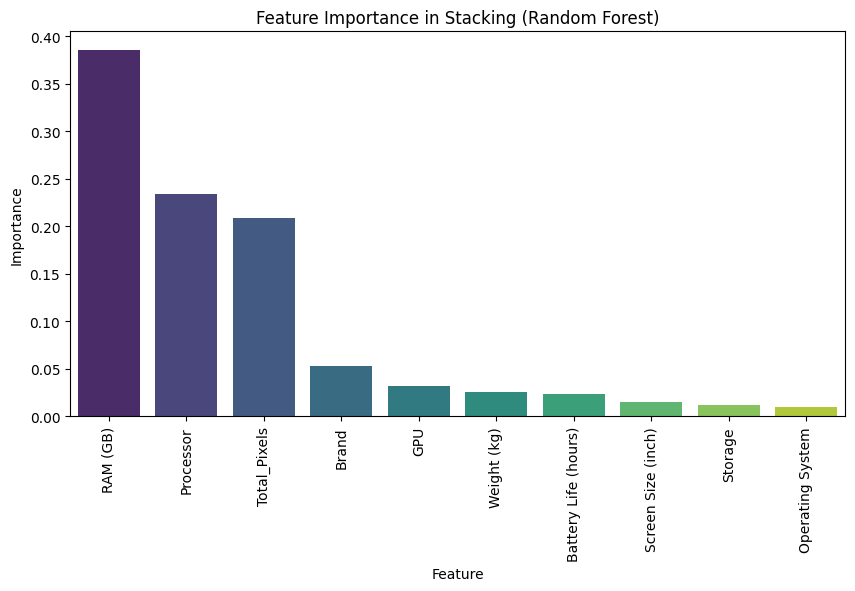

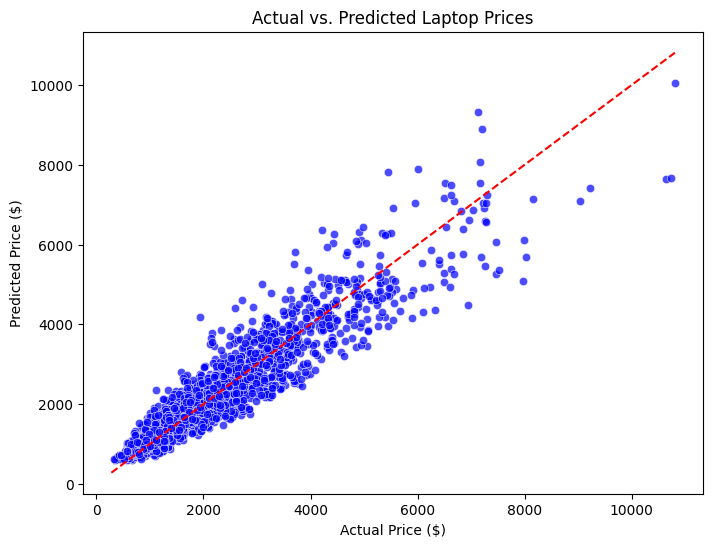

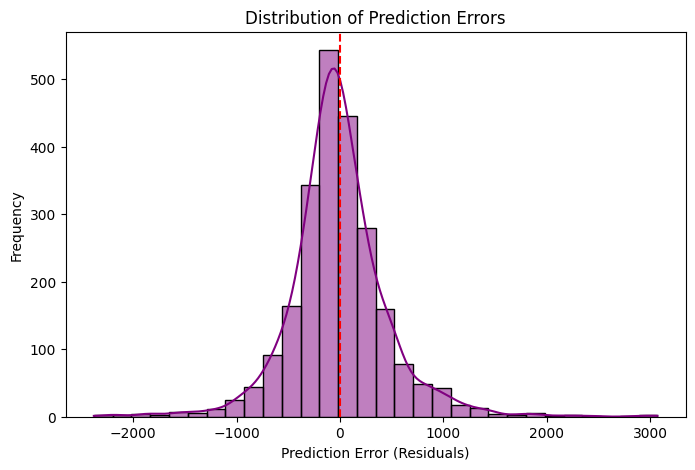

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
file_path = r"C:\Users\Sanjay\Desktop\ML Tutorial\archive\laptop_prices.csv"
df = pd.read_csv(file_path)

# Convert Storage to numerical format
df['Storage'] = df['Storage'].str.extract(r'(\d+)').dropna().astype(float)

# Convert Resolution to total pixel count
df[['Width', 'Height']] = df['Resolution'].str.extract(r'(\d+)x(\d+)').astype(float)
df['Total_Pixels'] = df['Width'] * df['Height']
df.drop(columns=['Resolution', 'Width', 'Height'], inplace=True)  # Drop old Resolution column

# Encode categorical variables
for col in ['Brand', 'Processor', 'GPU', 'Operating System']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features and target
X = df.drop(columns=['Price ($)'])
y = df['Price ($)']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('decision_tree', DecisionTreeRegressor(max_depth=4)),
    ('random_forest', RandomForestRegressor(n_estimators=10, random_state=42)),
    ('adaboost', AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=10, random_state=42))
]

# Meta-model
meta_model = Ridge(alpha=1.0)

# Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train model
stacking_model.fit(X_train, y_train)

# Predictions
y_pred = stacking_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}, R² Score: {r2:.4f}")
print(f"Final Accuracy (R² Score): {r2 * 100:.2f}%")

# -------------------------------------------
# 📊 VISUALIZATIONS
# -------------------------------------------

# 🔹 1. Feature Importance (from Random Forest)
feature_importances = stacking_model.named_estimators_['random_forest'].feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=X.columns[sorted_indices], y=feature_importances[sorted_indices], palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Stacking (Random Forest)")
plt.show()

# 🔹 2. Predicted vs. Actual Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="blue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Ideal prediction line
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs. Predicted Laptop Prices")
plt.show()

# 🔹 3. Residual Errors Histogram
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.axvline(0, color='red', linestyle='dashed')  # Mean error line
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()
